In [ ]:
! pip install simpy pandas matplotlib

In [ ]:
import simpy
import random
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle
import numpy as np
import time

In [ ]:
@dataclass
class SimulationConfig:
    """Configuration parameters for the simulation"""
    # Simulation parameters
    SIM_TIME = 3600  # Total simulation time in seconds (1 hour)
    WARM_UP_TIME = 900  # Warm-up time in seconds (15 minutes)

    # Traffic parameters
    ARRIVAL_RATES = {
        'balanced_moderate': {'north': 300, 'south': 300, 'east': 300, 'west': 300},
        'unbalanced_peak': {'north': 750, 'south': 750, 'east': 300, 'west': 300}
    }

    TURN_PROBABILITIES = {'straight': 0.7, 'left': 0.2, 'right': 0.1}

    # Traffic light parameters
    MIN_GREEN_TIME = 15  # Minimum green time in seconds
    MAX_GREEN_TIME = 90  # Maximum green time in seconds
    YELLOW_TIME = 4      # Yellow/clearance time in seconds
    QUEUE_THRESHOLD = 5  # Queue length to trigger phase change
    EXTENSION_INCREMENT = 5  # Green time extension increment

    # Vehicle parameters
    INTERSECTION_CROSSING_TIME = 2.5  # Time to cross intersection
    LANE_CAPACITY = 20  # Maximum vehicles per lane

    # Visualization parameters
    ROAD_LENGTH = 100  # Length of each road in visualization units
    INTERSECTION_SIZE = 40  # Size of the intersection area
    CAR_SIZE = 4  # Size of cars in visualization

In [ ]:
class Vehicle:
    """Represents a vehicle in the simulation"""
    def __init__(self, vehicle_id, arrival_time, entry_direction, movement_type):
        self.id = vehicle_id
        self.arrival_time = arrival_time
        self.entry_direction = entry_direction
        self.movement_type = movement_type
        self.waiting_time = 0
        self.service_start_time = None
        self.exit_time = None

In [ ]:
class TrafficLightSystem:
    """Manages the adaptive traffic light system"""
    def __init__(self, env):
        self.env = env
        self.current_phase = 'north_south_green'
        self.phase_history = []

        # Define phase relationships
        self.phase_relationships = {
            'north_south_green': ['east', 'west'],  # Opposing directions
            'east_west_green': ['north', 'south']
        }

    def get_opposing_directions(self, phase):
        """Get directions that are currently red in the given phase"""
        return self.phase_relationships.get(phase, [])

    def log_phase_change(self, from_phase, to_phase, reason):
        """Log phase changes for analysis"""
        self.phase_history.append({
            'time': self.env.now,
            'from_phase': from_phase,
            'to_phase': to_phase,
            'reason': reason
        })

In [ ]:
class Intersection:
    """Represents the four-way intersection"""
    def __init__(self, env, config):
        self.env = env
        self.config = config
        self.traffic_light = TrafficLightSystem(env)

        # Create lanes as SimPy resources with capacity
        self.lanes = {
            'north': simpy.Resource(env, capacity=config.LANE_CAPACITY),
            'south': simpy.Resource(env, capacity=config.LANE_CAPACITY),
            'east': simpy.Resource(env, capacity=config.LANE_CAPACITY),
            'west': simpy.Resource(env, capacity=config.LANE_CAPACITY)
        }

        # Queue tracking
        self.queues = {direction: [] for direction in ['north', 'south', 'east', 'west']}
        self.vehicle_counter = 0
        self.completed_vehicles = []

        # Statistics
        self.queue_length_history = {direction: [] for direction in ['north', 'south', 'east', 'west']}

    def add_to_queue(self, vehicle, direction):
        """Add vehicle to queue and track queue length"""
        self.queues[direction].append(vehicle)
        self._record_queue_lengths()

    def remove_from_queue(self, vehicle, direction):
        """Remove vehicle from queue"""
        if vehicle in self.queues[direction]:
            self.queues[direction].remove(vehicle)
        self._record_queue_lengths()

    def _record_queue_lengths(self):
        """Record current queue lengths for analysis"""
        for direction in self.queues:
            self.queue_length_history[direction].append({
                'time': self.env.now,
                'queue_length': len(self.queues[direction])
            })

    def get_queue_length(self, direction):
        """Get current queue length for a direction"""
        return len(self.queues[direction])

    def get_opposing_queues(self, phase):
        """Get queue lengths for opposing directions"""
        opposing_dirs = self.traffic_light.get_opposing_directions(phase)
        return [self.get_queue_length(dir) for dir in opposing_dirs]

In [ ]:
class TrafficSimulation:
    """Main simulation class"""
    def __init__(self, config, scenario='balanced_moderate'):
        self.config = config
        self.env = simpy.Environment()
        self.intersection = Intersection(self.env, config)
        self.scenario = scenario
        self.arrival_rates = config.ARRIVAL_RATES[scenario]

    def vehicle_generator(self, direction):
        """Generate vehicles arriving at the intersection"""
        while True:
            # Exponential inter-arrival time based on arrival rate
            arrival_rate = self.arrival_rates[direction]
            inter_arrival_time = random.expovariate(arrival_rate / 3600.0)  # Convert to seconds

            yield self.env.timeout(inter_arrival_time)

            # Create new vehicle
            movement_type = random.choices(
                list(self.config.TURN_PROBABILITIES.keys()),
                weights=list(self.config.TURN_PROBABILITIES.values())
            )[0]

            vehicle = Vehicle(
                vehicle_id=self.intersection.vehicle_counter,
                arrival_time=self.env.now,
                entry_direction=direction,
                movement_type=movement_type
            )

            self.intersection.vehicle_counter += 1
            self.intersection.add_to_queue(vehicle, direction)

            # Start vehicle process
            self.env.process(self.vehicle_process(vehicle, direction))

    def vehicle_process(self, vehicle, direction):
        """Process for each vehicle moving through the intersection"""
        # Wait for green light and lane availability
        with self.intersection.lanes[direction].request() as request:
            yield request

            # Wait for appropriate green light phase
            if direction in ['north', 'south']:
                required_phase = 'north_south_green'
            else:
                required_phase = 'east_west_green'

            # Wait until our phase is active
            while self.intersection.traffic_light.current_phase != required_phase:
                yield self.env.timeout(1)  # Check every second

            # Vehicle can now proceed
            vehicle.service_start_time = self.env.now
            vehicle.waiting_time = vehicle.service_start_time - vehicle.arrival_time

            # Remove from queue
            self.intersection.remove_from_queue(vehicle, direction)

            # Time to cross intersection
            yield self.env.timeout(self.config.INTERSECTION_CROSSING_TIME)

            # Vehicle exits
            vehicle.exit_time = self.env.now
            self.intersection.completed_vehicles.append(vehicle)

    def adaptive_traffic_controller(self):
        """Adaptive traffic light controller process"""
        while True:
            current_phase = self.intersection.traffic_light.current_phase
            green_time = self.config.MIN_GREEN_TIME

            # Execute minimum green time
            yield self.env.timeout(green_time)

            # Adaptive extension logic
            extensions = 0
            while green_time < self.config.MAX_GREEN_TIME:
                # Check opposing queue lengths
                opposing_queues = self.intersection.get_opposing_queues(current_phase)
                max_opposing_queue = max(opposing_queues) if opposing_queues else 0

                # Decision point: switch if opposing queue exceeds threshold
                if max_opposing_queue >= self.config.QUEUE_THRESHOLD:
                    reason = f"Opposing queue reached threshold: {max_opposing_queue}"
                    break

                # Otherwise extend green time
                yield self.env.timeout(self.config.EXTENSION_INCREMENT)
                green_time += self.config.EXTENSION_INCREMENT
                extensions += 1
            else:
                reason = "Reached maximum green time"

            # Yellow clearance interval
            yield self.env.timeout(self.config.YELLOW_TIME)

            # Switch to next phase
            next_phase = 'east_west_green' if current_phase == 'north_south_green' else 'north_south_green'

            # Log the phase change
            self.intersection.traffic_light.log_phase_change(
                current_phase, next_phase, reason
            )

            # Update current phase
            self.intersection.traffic_light.current_phase = next_phase

    def run(self):
        """Run the simulation"""
        # Start vehicle generators for all directions
        for direction in ['north', 'south', 'east', 'west']:
            self.env.process(self.vehicle_generator(direction))

        # Start adaptive traffic controller
        self.env.process(self.adaptive_traffic_controller())

        # Run simulation
        self.env.run(until=self.config.SIM_TIME)

    def get_results(self):
        """Extract and return simulation results"""
        if not self.intersection.completed_vehicles:
            return {}

        completed_vehicles = self.intersection.completed_vehicles

        # Filter out warm-up period vehicles
        analysis_vehicles = [v for v in completed_vehicles
                           if v.arrival_time >= self.config.WARM_UP_TIME]

        if not analysis_vehicles:
            return {}

        # Calculate statistics
        waiting_times = [v.waiting_time for v in analysis_vehicles]
        total_times = [v.exit_time - v.arrival_time for v in analysis_vehicles]

        results = {
            'scenario': self.scenario,
            'total_vehicles_generated': self.intersection.vehicle_counter,
            'total_vehicles_completed': len(completed_vehicles),
            'vehicles_analyzed': len(analysis_vehicles),
            'average_waiting_time': sum(waiting_times) / len(waiting_times),
            'average_total_time': sum(total_times) / len(total_times),
            'max_waiting_time': max(waiting_times),
            'throughput_vehicles_per_hour': len(analysis_vehicles) / (self.config.SIM_TIME - self.config.WARM_UP_TIME) * 3600,
            'phase_changes': len(self.intersection.traffic_light.phase_history)
        }

        # Queue statistics
        for direction in self.intersection.queue_length_history:
            queue_lengths = [q['queue_length'] for q in self.intersection.queue_length_history[direction]
                           if q['time'] >= self.config.WARM_UP_TIME]
            if queue_lengths:
                results[f'{direction}_avg_queue'] = sum(queue_lengths) / len(queue_lengths)
                results[f'{direction}_max_queue'] = max(queue_lengths)

        return results

In [ ]:
def run_scenario_analysis():
    """Run simulation for different scenarios and analyze results"""
    config = SimulationConfig()
    scenarios = ['balanced_moderate', 'unbalanced_peak']

    all_results = []

    for scenario in scenarios:
        print(f"\nRunning {scenario} scenario...")

        # Run simulation
        sim = TrafficSimulation(config, scenario)
        sim.run()

        # Get results
        results = sim.get_results()
        if results:
            all_results.append(results)

            print(f"Results for {scenario}:")
            print(f"  Average Waiting Time: {results['average_waiting_time']:.2f} seconds")
            print(f"  Throughput: {results['throughput_vehicles_per_hour']:.1f} vehicles/hour")
            print(f"  Phase Changes: {results['phase_changes']}")
            print(f"  Max Queue (N-S): {results.get('north_max_queue', 0)}")
            print(f"  Max Queue (E-W): {results.get('east_max_queue', 0)}")

    # Create comparative analysis
    if all_results:
        df_results = pd.DataFrame(all_results)
        print("\n" + "="*50)
        print("COMPARATIVE ANALYSIS")
        print("="*50)
        print(df_results.to_string(index=False))

        # Plot results
        plot_results(df_results)

    return all_results

In [ ]:
def plot_results(results_df):
    """Create visualization of results"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot 1: Average Waiting Time
    axes[0,0].bar(results_df['scenario'], results_df['average_waiting_time'], color=['skyblue', 'lightcoral'])
    axes[0,0].set_title('Average Waiting Time by Scenario')
    axes[0,0].set_ylabel('Seconds')

    # Plot 2: Throughput
    axes[0,1].bar(results_df['scenario'], results_df['throughput_vehicles_per_hour'], color=['skyblue', 'lightcoral'])
    axes[0,1].set_title('Throughput by Scenario')
    axes[0,1].set_ylabel('Vehicles per Hour')

    # Plot 3: Queue Lengths
    scenarios = results_df['scenario'].tolist()
    north_queues = [results_df.iloc[i].get('north_avg_queue', 0) for i in range(len(results_df))]
    east_queues = [results_df.iloc[i].get('east_avg_queue', 0) for i in range(len(results_df))]

    x = range(len(scenarios))
    width = 0.35
    axes[1,0].bar(x, north_queues, width, label='North-South', color='blue')
    axes[1,0].bar([i + width for i in x], east_queues, width, label='East-West', color='red')
    axes[1,0].set_title('Average Queue Length by Direction')
    axes[1,0].set_ylabel('Number of Vehicles')
    axes[1,0].set_xticks([i + width/2 for i in x])
    axes[1,0].set_xticklabels(scenarios)
    axes[1,0].legend()

    # Plot 4: Phase Changes
    axes[1,1].bar(results_df['scenario'], results_df['phase_changes'], color=['skyblue', 'lightcoral'])
    axes[1,1].set_title('Number of Phase Changes')
    axes[1,1].set_ylabel('Count')

    plt.tight_layout()
    plt.savefig('traffic_simulation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

Starting Adaptive Traffic Light Simulation...
This may take a few moments...

Running balanced_moderate scenario...
Results for balanced_moderate:
  Average Waiting Time: 12.07 seconds
  Throughput: 1238.7 vehicles/hour
  Phase Changes: 69
  Max Queue (N-S): 9
  Max Queue (E-W): 7

Running unbalanced_peak scenario...
Results for unbalanced_peak:
  Average Waiting Time: 6.93 seconds
  Throughput: 2097.3 vehicles/hour
  Phase Changes: 94
  Max Queue (N-S): 10
  Max Queue (E-W): 8

COMPARATIVE ANALYSIS
         scenario  total_vehicles_generated  total_vehicles_completed  vehicles_analyzed  average_waiting_time  average_total_time  max_waiting_time  throughput_vehicles_per_hour  phase_changes  north_avg_queue  north_max_queue  south_avg_queue  south_max_queue  east_avg_queue  east_max_queue  west_avg_queue  west_max_queue
balanced_moderate                      1220                      1213                929             12.073197           14.573197              86.0                   12

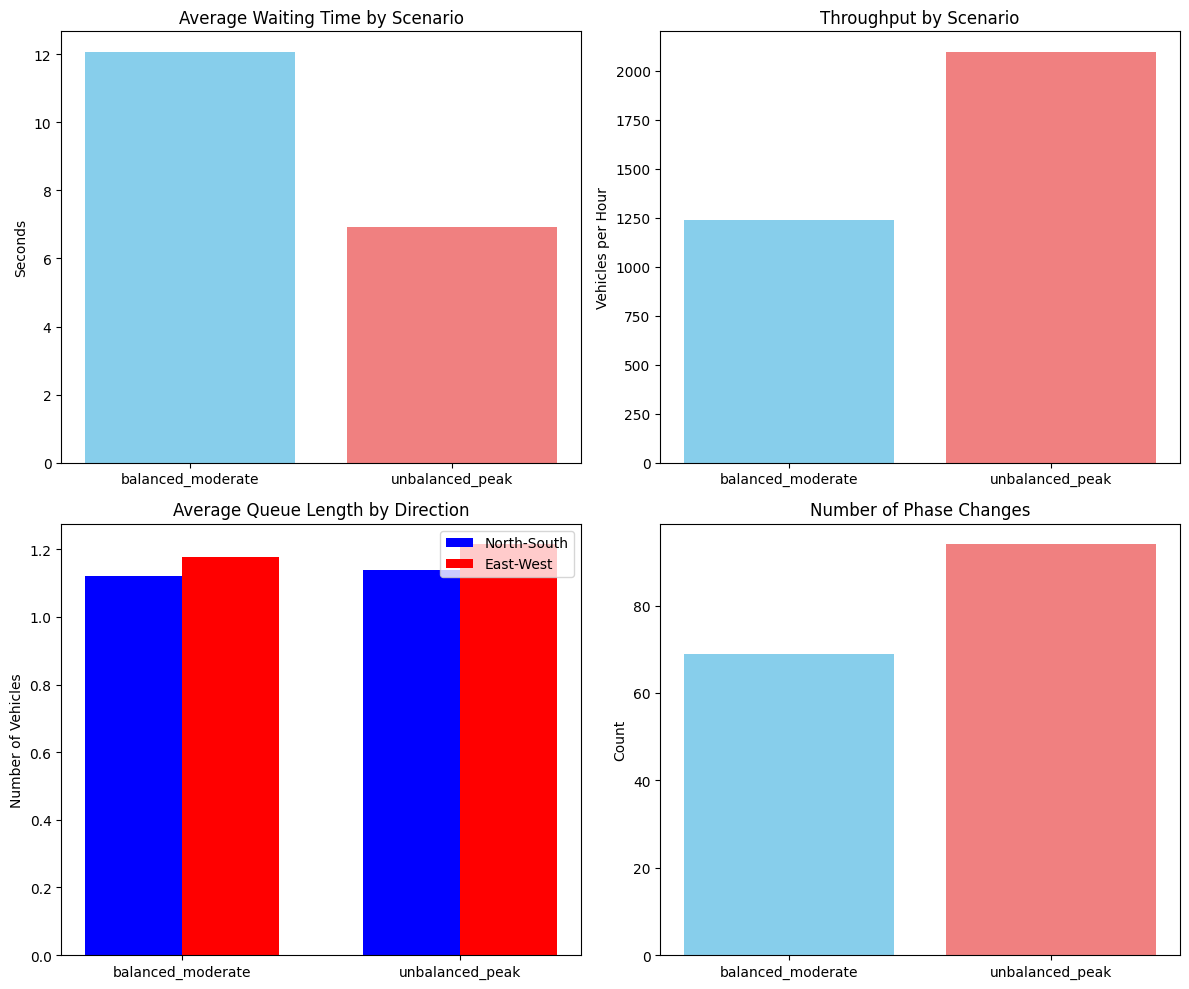


Simulation completed! Check 'traffic_simulation_results.png' for visualizations.


In [ ]:
'''
if __name__ == "__main__":
    print("Starting Adaptive Traffic Light Simulation...")
    print("This may take a few moments...")

    results = run_scenario_analysis()

    print("\nSimulation completed! Check 'traffic_simulation_results.png' for visualizations.")
'''

print("Starting Adaptive Traffic Light Simulation...")
print("This may take a few moments...")
results = run_scenario_analysis()
print("\nSimulation completed! Check 'traffic_simulation_results.png' for visualizations.")

Starting Adaptive Traffic Light Simulation...
This may take a few moments...

Running balanced_moderate scenario...
Results for balanced_moderate:
  Average Waiting Time: 11.51 seconds
  Throughput: 1109.3 vehicles/hour
  Phase Changes: 67
  Max Queue (N-S): 7
  Max Queue (E-W): 7

Running unbalanced_peak scenario...
Results for unbalanced_peak:
  Average Waiting Time: 7.58 seconds
  Throughput: 2114.7 vehicles/hour
  Phase Changes: 94
  Max Queue (N-S): 9
  Max Queue (E-W): 6

COMPARATIVE ANALYSIS
         scenario  total_vehicles_generated  total_vehicles_completed  vehicles_analyzed  average_waiting_time  average_total_time  max_waiting_time  throughput_vehicles_per_hour  phase_changes  north_avg_queue  north_max_queue  south_avg_queue  south_max_queue  east_avg_queue  east_max_queue  west_avg_queue  west_max_queue
balanced_moderate                      1124                      1120                832             11.506010           14.006010              94.0                   110

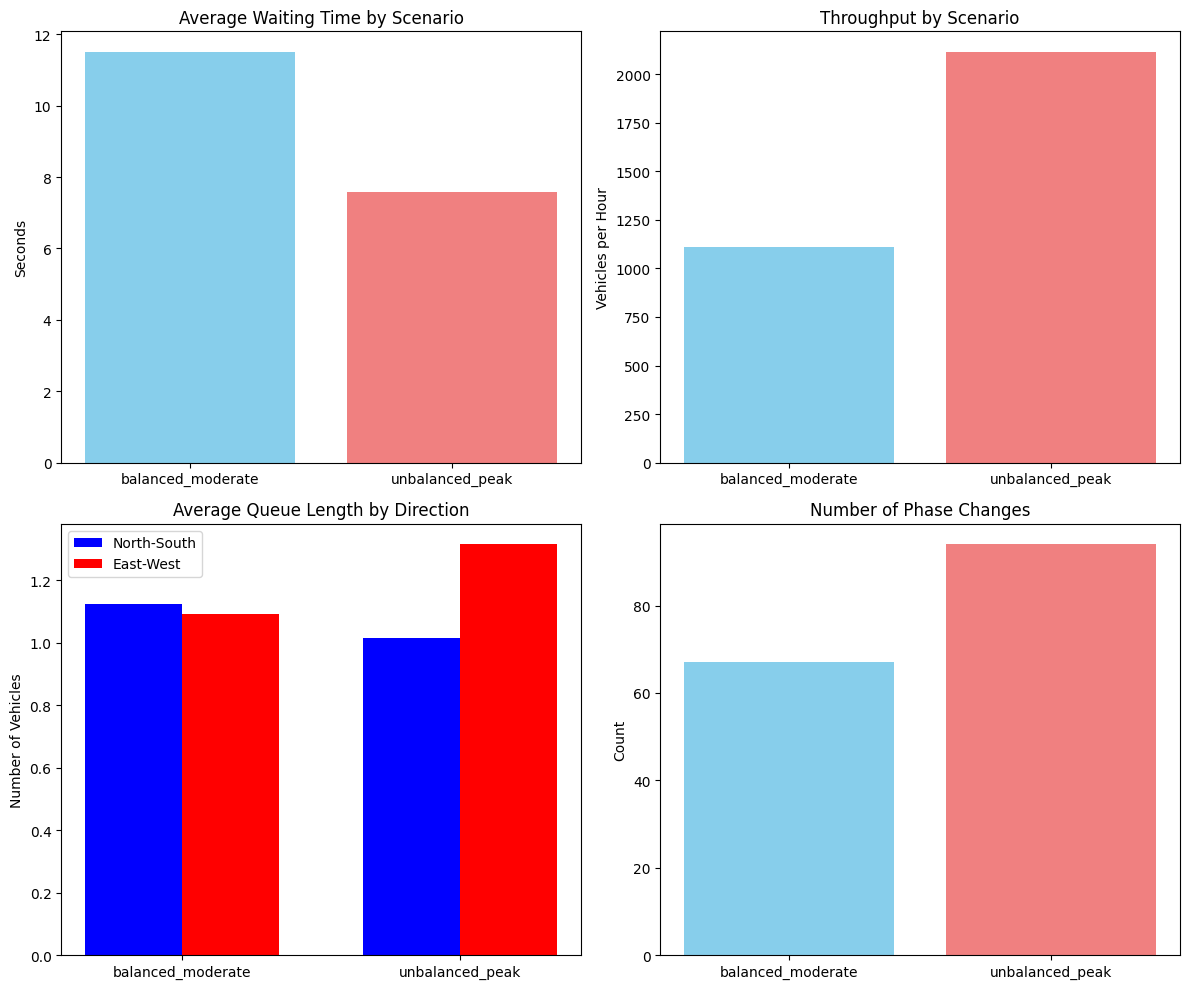


Simulation completed! Check 'traffic_simulation_results.png' for visualizations.


In [ ]:
'''
if __name__ == "__main__":
    print("Starting Adaptive Traffic Light Simulation...")
    print("This may take a few moments...")

    results = run_scenario_analysis()

    print("\nSimulation completed! Check 'traffic_simulation_results.png' for visualizations.")
'''
print("Starting Adaptive Traffic Light Simulation...")
print("This may take a few moments...")

results = run_scenario_analysis()

print("\nSimulation completed! Check 'traffic_simulation_results.png' for visualizations.")